In [1]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('data/stock_filing_data.csv')

In [3]:
display(df.head(10))
display(df.describe())

,filing_date,gics_sector,company_id,date,filing_released,n_calendar,n_trading,close,close_next_n,percent_growth
0,2018-01-22,Information Technology,2236,2018-01-29,1,7,5,197.8400,198.2300,0.001971
1,2018-01-22,Information Technology,2236,2018-01-26,1,4,4,197.8400,201.3000,0.017489
2,2018-01-22,Information Technology,2236,2018-01-23,1,1,1,197.8400,200.0900,0.011373
3,2018-01-22,Information Technology,2236,2018-01-22,1,0,0,197.8400,197.8400,0.000000
4,2018-01-22,Information Technology,2236,2018-01-24,1,2,2,197.8400,197.7800,-0.000303
5,2018-01-22,Information Technology,2236,2018-01-25,1,3,3,197.8400,197.5100,-0.001668
6,2018-01-22,Information Technology,15237,2018-01-29,0,7,5,254.2695,249.0841,-0.020393
7,2018-01-22,Information Technology,29618,2018-01-22,0,0,0,156.5710,156.5710,0.000000
8,2018-01-22,Information Technology,15237,2018-01-26,0,4,4,254.2695,254.2695,0.000000
9,2018-01-22,Information Technology,15237,2018-01-25,0,3,3,254.2695,245.5300,-0.034371


,company_id,filing_released,n_calendar,n_trading,close,close_next_n,percent_growth
count,145880.000000,145880.000000,145880.000000,145880.000000,145880.000000,145880.000000,145880.000000
mean,9176.696031,0.037565,3.554833,2.401529,116.304532,116.431583,0.000980
std,10176.751878,0.190143,2.516643,1.666983,159.411843,159.828379,0.028021
min,6.000000,0.000000,0.000000,0.000000,6.758800,6.637100,-0.384850
25%,1306.000000,0.000000,1.000000,1.000000,48.955550,49.008025,-0.008891
50%,4997.000000,0.000000,4.000000,2.000000,82.094900,82.173400,0.000000
75%,14221.000000,0.000000,6.000000,4.000000,136.558300,136.465000,0.012031
max,35080.000000,1.000000,7.000000,5.000000,2188.900000,2188.900000,0.582145


### Dataset Overview

* Samples: 145,880
* Timeline
    * From 2018-01-01
    * To 2019-12-27
* Number of Industry Sectors: 11
* Companies: 479
* Sampling Pool: S&P 500

### Features

* filing_date: Date when annual report (10-k) has been published
* gics_sector: Sector (Industry) where the company primarily conducts business
* company_id: Company Identifier (in this study we don't disclose company names)
* date: Calendar Date (always ahead of filing_date) at which 'close_next_n' has been recorded
* filing_released: Boolean flag indicating whther a company has released a report as of the row's filing_date
* n_calendar: Number of calendar days since filing_date
* n_trading: Number of trading days (weekdays excluding holidays) since filing_date
* close: Closing price as of 'filing_date'
* close_next_n: Closing price as of 'date'
* percent_growth: Percent change (growth) in price from 'close' to 'close_next_n'


### How it was built

This dataset was generated to study the effect of financial statement release (10-K report) on the behaviour of stock prices of the corresponding company shortly after the report became public. Population of this dataset started with identifying companies that released their financial report and date of their filings, generating unique combinations of company_id, filing_date and filing_released=1. For each such combination, complimentary combinations of companies that did not release their financial report (filing_released=0) at filinng_date but belonged to the same industry were generated. Finally, each combination was extended (duplicated) to cover the timeline of date = [filing_date, filing_date + 7 calendar days] for each company, keeping track of stock prices at those dates.

### Lets get started!
We want to see price change between sample at n=1 and sample n=1+shift (several days ahead of n=1). To do this, we will create df_shift and update 'n' column to become 'n' minus 'shift'. This way, we can join df_ and df_shift so that df_[n] is in the same row with df[n+shift].

In [4]:
shift = 2
df_ = df.copy()
df_shift = df_.copy()
df_shift['n_trading'] = df_shift['n_trading'] - shift
display(df_.head())
display(df_shift.head())

,filing_date,gics_sector,company_id,date,filing_released,n_calendar,n_trading,close,close_next_n,percent_growth
0,2018-01-22,Information Technology,2236,2018-01-29,1,7,5,197.84,198.23,0.001971
1,2018-01-22,Information Technology,2236,2018-01-26,1,4,4,197.84,201.30,0.017489
2,2018-01-22,Information Technology,2236,2018-01-23,1,1,1,197.84,200.09,0.011373
3,2018-01-22,Information Technology,2236,2018-01-22,1,0,0,197.84,197.84,0.000000
4,2018-01-22,Information Technology,2236,2018-01-24,1,2,2,197.84,197.78,-0.000303


,filing_date,gics_sector,company_id,date,filing_released,n_calendar,n_trading,close,close_next_n,percent_growth
0,2018-01-22,Information Technology,2236,2018-01-29,1,7,3,197.84,198.23,0.001971
1,2018-01-22,Information Technology,2236,2018-01-26,1,4,2,197.84,201.30,0.017489
2,2018-01-22,Information Technology,2236,2018-01-23,1,1,-1,197.84,200.09,0.011373
3,2018-01-22,Information Technology,2236,2018-01-22,1,0,-2,197.84,197.84,0.000000
4,2018-01-22,Information Technology,2236,2018-01-24,1,2,0,197.84,197.78,-0.000303


<b>Note</b> above how entries with the same index have different values in the 'n' column.
In the following step, we will join df_ and df_shift using 'company_id', 'filing_date' and 'n_trading'.

In [5]:
index_columns = ['company_id', 'filing_date', 'n_trading']
print(f'Size before merge: {len(df_)}')
df_merged = df_.set_index(index_columns).join(
    df_shift.set_index(index_columns), 
    how='inner',
    rsuffix='_after_shift_days'
).reset_index()
print(f'Size after merge: {len(df_merged)}')
df_merged[['company_id', 'filing_date', 'date', 'date_after_shift_days', 'close_next_n', 'close_next_n_after_shift_days']].head()

Size before merge: 145880
Size after merge: 95312


,company_id,filing_date,date,date_after_shift_days,close_next_n,close_next_n_after_shift_days
0,154,2019-10-28,2019-10-29,2019-10-31,53.0129,54.0253
1,1758,2018-01-24,2018-01-26,2018-01-30,69.9201,68.4282
2,753,2019-03-18,2019-03-19,2019-03-21,57.6698,57.5231
3,281,2019-01-31,2019-02-05,2019-02-07,62.2851,61.7466
4,1060,2019-02-27,2019-02-28,2019-03-04,58.2992,60.4408


<b>To make sure</b> I've done the join correctly, we can see above how 'date' is 2 days before 'date_after_shift_days'. The size the dataframe shrinks from 145,880 to 95,312 entries due to the fact that n_trading differs between df_merge [0:5] and df_shift [-2:3].

<b>Next</b>, we're going to filter the table to n (n_trading) = 1, leaving ourselves with entries corresponding to exactly 1 day since a financial statement report has been released. Rows where n=1 will also have information on n=3, coming from the above join. We will also filter out entries where price growth during the first day was less than 1%, assuming there was weak momentum and the public did not feel particularly good about the filing.

In [6]:
df_merged = df_merged[df_merged['n_trading'] == 1]
df_merged['growth_increment'] = df_merged['percent_growth_after_shift_days'] - df_merged['percent_growth']

# Computing how price changed at n=3 compared to n=1 (percent change)
df_merged['price_growth_during_shift_days'] = df_merged['close_next_n_after_shift_days'] / df_merged['close_next_n'] - 1
display(df_merged[['company_id', 'filing_date', 'n_trading', 'percent_growth', 'price_growth_during_shift_days']].head())

,company_id,filing_date,n_trading,percent_growth,price_growth_during_shift_days
0,154,2019-10-28,1,-0.002987,0.019097
2,753,2019-03-18,1,0.001019,-0.002544
4,1060,2019-02-27,1,-0.011880,0.036735
7,942,2019-11-15,1,-0.011324,-0.054061
10,3619,2019-02-21,1,0.004128,-0.003008


<b>Note</b>: 'percent_growth' represents how price grew between n=0 and n=1 (initial reaction to the financial statement release) while 'price_growth_during_shift_days' represents price change between n=1 and n=3.

This completes our data wrangling phase. At this point, we can compare whether the event of financial statement release can be used to say anything about how price will behave in the near future, in this case between day 1 and day 3 after the statement became public.

We will also apply a threshold of 0.01 (1% stock price increase) on 'percent_growth' for companies that released their filings to identify companies that had strong momentum in the first day of the statement release.

In [7]:
# Let's define a printing function (don't focus too much on this one - it just makes a nice histogram)
def print_hist(positive, negative, title=''):
    """ Prints an overlapping histogram of two arrays """

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=positive,
        histnorm='percent',
        name='Filing Released', # name used in legend and hover labels
        xbins=dict( # bins used for histogram
            start=-0.1,
            end=0.1,
            size=0.01
        ),
        marker_color='#EB89B5',
        opacity=0.75
    ))
    
    fig.add_trace(go.Histogram(
        x=negative,
        histnorm='percent',
        name='Ordinary Day',
        xbins=dict(
            start=-0.1,
            end=0.1,
            size=0.01
        ),
        marker_color='#330C73',
        opacity=0.75
    ))
    
    fig.update_layout(
        title_text=title, # title of plot
        xaxis_title_text='Inremental Price Increase', # xaxis label
        yaxis_title_text='Samples, %', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates
    )
    
    fig.show("png")

<b>Note:</b> Logistics out of the way. Now to the actual code!

,company_id,filing_date,n_trading,gics_sector,date,filing_released,n_calendar,close,close_next_n,percent_growth,gics_sector_after_shift_days,date_after_shift_days,filing_released_after_shift_days,n_calendar_after_shift_days,close_after_shift_days,close_next_n_after_shift_days,percent_growth_after_shift_days,growth_increment,price_growth_during_shift_days
1408,1260,2018-02-22,1,Energy,2018-02-23,1,1,102.7191,105.2429,0.024570,Energy,2018-02-27,1,5,102.7191,106.1964,0.033853,0.009283,0.009060
1743,280,2019-12-19,1,Industrials,2019-12-20,1,1,172.7762,174.6800,0.011019,Industrials,2019-12-24,1,5,172.7762,174.4230,0.009531,-0.001487,-0.001471
1763,383,2019-02-28,1,Materials,2019-03-01,1,1,76.4925,77.2959,0.010503,Materials,2019-03-05,1,5,76.4925,77.9375,0.018891,0.008388,0.008301
1811,15137,2018-02-23,1,Real Estate,2018-02-26,1,3,143.8800,146.0934,0.015384,Real Estate,2018-02-28,1,5,143.8800,140.9870,-0.020107,-0.035491,-0.034953
1823,257,2019-02-07,1,Health Care,2019-02-08,1,1,179.3737,181.2692,0.010567,Health Care,2019-02-12,1,5,179.3737,184.2463,0.027165,0.016597,0.016424


,company_id,filing_date,n_trading,gics_sector,date,filing_released,n_calendar,close,close_next_n,percent_growth,gics_sector_after_shift_days,date_after_shift_days,filing_released_after_shift_days,n_calendar_after_shift_days,close_after_shift_days,close_next_n_after_shift_days,percent_growth_after_shift_days,growth_increment,price_growth_during_shift_days
0,154,2019-10-28,1,Consumer Staples,2019-10-29,0,1,53.1717,53.0129,-0.002987,Consumer Staples,2019-10-31,0,3,53.1717,54.0253,0.016054,0.019040,0.019097
2,753,2019-03-18,1,Materials,2019-03-19,0,1,57.6111,57.6698,0.001019,Materials,2019-03-21,0,3,57.6111,57.5231,-0.001527,-0.002546,-0.002544
4,1060,2019-02-27,1,Utilities,2019-02-28,0,1,59.0001,58.2992,-0.011880,Utilities,2019-03-04,0,5,59.0001,60.4408,0.024419,0.036298,0.036735
7,942,2019-11-15,1,Consumer Discretionary,2019-11-18,0,3,37.6025,37.1767,-0.011324,Consumer Discretionary,2019-11-20,0,5,37.6025,35.1669,-0.064772,-0.053449,-0.054061
10,3619,2019-02-21,1,Industrials,2019-02-22,0,1,97.4984,97.9009,0.004128,Industrials,2019-02-26,0,5,97.4984,97.6064,0.001108,-0.003021,-0.003008


Shift = 2, Threshold = 0.01
Filing Released: mean=-0.001, std=0.025, number_of_samples=257
Ordinary Day: mean=0.002, std=0.026, number_of_samples=24315
P-value: 0.072




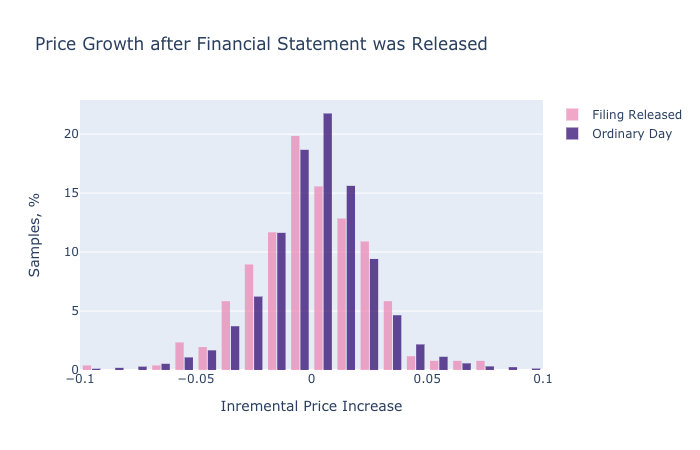

In [8]:
th = 0.01

# Extract samples for companies that published their reports
filing_released_samples = list(df_merged[(df_merged['filing_released'] == 1) & (df_merged['percent_growth'] >= th)]['price_growth_during_shift_days'])
display(df_merged[(df_merged['filing_released'] == 1) & (df_merged['percent_growth'] > th)].head())

# Extract samples for companies that did not publish their reports
ordinary_day_samples = list(df_merged[(df_merged['filing_released'] == 0)]['price_growth_during_shift_days'])
display(df_merged[(df_merged['filing_released'] == 0)].head())

# Get some basic statistics
t_score, p_value = ttest_ind(filing_released_samples, ordinary_day_samples, equal_var=False)
print(f'Shift = {shift}, Threshold = {th}')
print(f'Filing Released: mean={np.mean(filing_released_samples):.3f}, std={np.std(filing_released_samples):.3f}, number_of_samples={len(filing_released_samples):d}')
print(f'Ordinary Day: mean={np.mean(ordinary_day_samples):.3f}, std={np.std(ordinary_day_samples):.3f}, number_of_samples={len(ordinary_day_samples):d}')
print(f'P-value: {p_value:.3f}')
print('\n')

# Make a histogram
print_hist(filing_released_samples, ordinary_day_samples, 'Price Growth after Financial Statement was Released')

### Streamlining
Let's perform this analysis for a range of different shifts and price growth thresholds to find out whether there is a combination indicating significant diffirence between price behaviour among companies that released their financial statement and those that didn't.

In [9]:
# Wrap the process discribed above in a function for conveninet implementation
def evaluate(df, shift, th, display=True, title=''):
    df_ = df.copy()
    df_shift = df_.copy()
    df_shift['n_trading'] = df_shift['n_trading'] - shift
    index_columns = ['company_id', 'filing_date', 'n_trading']
    df_merged = df_.set_index(index_columns).join(
        df_shift.set_index(index_columns), 
        how='inner',
        rsuffix='_after_shift_days'
    ).reset_index()
    df_merged = df_merged[df_merged['n_trading'] == 1]
    df_merged['growth_increment'] = df_merged['percent_growth_after_shift_days'] - df_merged['percent_growth']
    df_merged['price_growth_during_n_days'] = df_merged['close_next_n_after_shift_days'] / df_merged['close_next_n'] - 1

    filing_released_samples = list(df_merged[(df_merged['filing_released'] == 1) & (df_merged['percent_growth'] > th)]['price_growth_during_n_days'])
    ordinary_day_samples = list(df_merged[(df_merged['filing_released'] == 0)]['price_growth_during_n_days'])
    
    if display:
        print_hist(filing_released_samples, ordinary_day_samples, title=title)
        
    t_score, p_value = ttest_ind(filing_released_samples, ordinary_day_samples, equal_var=False)
    
    print(f'Shift = {shift}, Threshold = {th}')
    print(f'Filing Released: mean={np.mean(filing_released_samples):.3f}, std={np.std(filing_released_samples):.3f}, number_of_samples={len(filing_released_samples):d}')
    print(f'Ordinary Day: mean={np.mean(ordinary_day_samples):.3f}, std={np.std(ordinary_day_samples):.3f}, number_of_samples={len(ordinary_day_samples):d}')
    print(f'P-value: {p_value:.3f}')
    print('\n')
    
# Define parameter space
shifts = [1, 2, 3, 4]
thresholds = [0.005, 0.01, 0.015]

# Iterate through the parameters and print out statistics
for shift in shifts:
    for th in thresholds:
        evaluate(df=df, shift=shift, th=th, display=False)

Shift = 1, Threshold = 0.005
Filing Released: mean=0.001, std=0.017, number_of_samples=372
Ordinary Day: mean=0.001, std=0.019, number_of_samples=24334
P-value: 0.851


Shift = 1, Threshold = 0.01
Filing Released: mean=0.001, std=0.018, number_of_samples=257
Ordinary Day: mean=0.001, std=0.019, number_of_samples=24334
P-value: 0.918


Shift = 1, Threshold = 0.015
Filing Released: mean=0.001, std=0.019, number_of_samples=156
Ordinary Day: mean=0.001, std=0.019, number_of_samples=24334
P-value: 0.823


Shift = 2, Threshold = 0.005
Filing Released: mean=-0.000, std=0.023, number_of_samples=372
Ordinary Day: mean=0.002, std=0.026, number_of_samples=24315
P-value: 0.031


Shift = 2, Threshold = 0.01
Filing Released: mean=-0.001, std=0.025, number_of_samples=257
Ordinary Day: mean=0.002, std=0.026, number_of_samples=24315
P-value: 0.072


Shift = 2, Threshold = 0.015
Filing Released: mean=-0.002, std=0.026, number_of_samples=156
Ordinary Day: mean=0.002, std=0.026, number_of_samples=24315
P-

### Observation
The most promising run (lowest p-value) was at shift=4 and threshold=0.01 (or 1% price growth during the first day after the filing). Let's take a closer look at it's histogram.

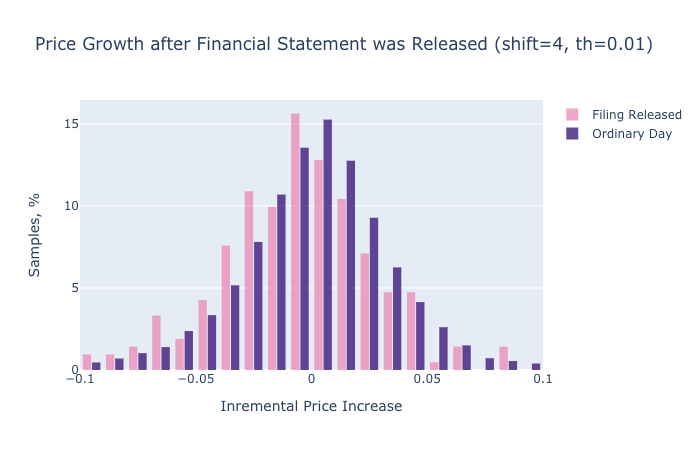

Shift = 4, Threshold = 0.01
Filing Released: mean=-0.006, std=0.034, number_of_samples=212
Ordinary Day: mean=0.002, std=0.038, number_of_samples=18859
P-value: 0.001




In [10]:
th = 0.01
shift = 4
evaluate(df=df, shift=shift, th=th, display=True, title=f'Price Growth after Financial Statement was Released (shift={shift}, th={th})')

<b>Indeed,</b> we can see that the historgram for the 'Filing Released' companies is shifted towards left comparad to the histogram for companies on an ordinary day. Keeping in mind that 'Filing Released' data has been conditioned on at least 1% price growth immediately after financial statement release. This leads us to conslusion that in the timerage of this study, between 2018 and 2020, companies on average had a tendency to correct their immediate growth within 4 days after their financial statement release comparad to other companies under (assumignly) normal market conditions.

<b>Next</b>, let's perform the same analysis segmenting our sampling space to the industry sectors. In other words, we will compare companies that released their financial statements only with companies that come from the same sector. This will allow us to reduce the number of random factors affecting our results. For example, if a given sector is experiencing strong up-trend, we'd want to compare companies that released financial statements as part of this up-trend with companies that didn't release their statements as part of this same up-trend, excluding companies form declining or drifting industries.

In [11]:
df_it = df[df['gics_sector'] == 'Information Technology']
print('Computing statistics for Informaion Technology sector\n')
shifts = [1, 2, 3, 4]
thresholds = [0.005, 0.01, 0.015]
for shift in shifts:
    for th in thresholds:
        evaluate(df=df_it, shift=shift, th=th, display=False)

Computing statistics for Informaion Technology sector

Shift = 1, Threshold = 0.005
Filing Released: mean=0.001, std=0.014, number_of_samples=47
Ordinary Day: mean=0.001, std=0.020, number_of_samples=5811
P-value: 0.820


Shift = 1, Threshold = 0.01
Filing Released: mean=0.002, std=0.015, number_of_samples=29
Ordinary Day: mean=0.001, std=0.020, number_of_samples=5811
P-value: 0.621


Shift = 1, Threshold = 0.015
Filing Released: mean=-0.001, std=0.015, number_of_samples=19
Ordinary Day: mean=0.001, std=0.020, number_of_samples=5811
P-value: 0.695


Shift = 2, Threshold = 0.005
Filing Released: mean=0.001, std=0.021, number_of_samples=47
Ordinary Day: mean=0.002, std=0.029, number_of_samples=5802
P-value: 0.770


Shift = 2, Threshold = 0.01
Filing Released: mean=0.003, std=0.022, number_of_samples=29
Ordinary Day: mean=0.002, std=0.029, number_of_samples=5802
P-value: 0.802


Shift = 2, Threshold = 0.015
Filing Released: mean=-0.001, std=0.018, number_of_samples=19
Ordinary Day: mean=0

In [12]:
df_it = df[df['gics_sector'] == 'Health Care']
print('Computing statistics for Consumer sector\n')
for shift in shifts:
    for th in thresholds:
        evaluate(df=df_it, shift=shift, th=th, display=False)

Computing statistics for Consumer sector

Shift = 1, Threshold = 0.005
Filing Released: mean=0.004, std=0.026, number_of_samples=48
Ordinary Day: mean=0.002, std=0.019, number_of_samples=3004
P-value: 0.457


Shift = 1, Threshold = 0.01
Filing Released: mean=0.005, std=0.027, number_of_samples=30
Ordinary Day: mean=0.002, std=0.019, number_of_samples=3004
P-value: 0.480


Shift = 1, Threshold = 0.015
Filing Released: mean=0.013, std=0.022, number_of_samples=18
Ordinary Day: mean=0.002, std=0.019, number_of_samples=3004
P-value: 0.056


Shift = 2, Threshold = 0.005
Filing Released: mean=0.000, std=0.031, number_of_samples=48
Ordinary Day: mean=0.004, std=0.025, number_of_samples=2994
P-value: 0.376


Shift = 2, Threshold = 0.01
Filing Released: mean=-0.001, std=0.032, number_of_samples=30
Ordinary Day: mean=0.004, std=0.025, number_of_samples=2994
P-value: 0.332


Shift = 2, Threshold = 0.015
Filing Released: mean=-0.001, std=0.036, number_of_samples=18
Ordinary Day: mean=0.004, std=0.0

### Conclusion

The goal of this study was to briefly assess whether the effect of financial statement release has some correlation with the stock price behaviour and to determine whether it's worth the effort to explore this topic in depth.

While some statistically significant observations were noted, the results overall show rather week correlation between the event of financial statement release and the stock behaviour.